In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB - conn
Connected oraDW_ANALYTICS - conn_aly


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DATA_RPT_SLKH_CUST_PRODUCT_ALL'
    SEL_SAMPLE = 'SAMPLE1_SUB3'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DATA_RPT_SLKH_CUST_PRODUCT_ALL X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DATA_RPT_SLKH_CUST_PRODUCT_ALL X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 495083


In [20]:
df

,PROCESS_DT,CUSTOMER_CDE,CUST_TYPE,CUST_STATUS,BH,IB,MB,PAY,TKTT,TK,...,SD_CREDIT,SD_PREPAID,PAYROLL,SD_PAYROLL,SD_SP_KHAC,OS_AMT_LCL,ACTUAL_AMT_LCL,LASTEST_TRANS_DT,REC_CREATE_DT,CUST_OPEN_DT
0,2022-11-18,12348538,CN,NGU DONG,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,NaN,0,0.0,1.200000e+03,2019-04-19,2022-11-19 15:02:43,2018-09-22
1,2022-11-18,1234856,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.000000e+00,NaT,2022-11-19 15:02:43,2009-09-05
2,2022-11-18,12348562,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.000000e+00,2020-05-05,2022-11-19 15:02:43,2018-09-22
3,2022-11-18,12349647,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.000000e+00,NaT,2022-11-19 15:02:43,2018-09-22
4,2022-11-18,12349656,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.000000e+00,NaT,2022-11-19 15:02:43,2018-09-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495078,2022-11-18,10488667,CN,HOAT DONG,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,NaN,0,0.0,6.360100e+04,2022-03-17,2022-11-19 15:02:43,2017-05-04
495079,2022-11-18,10488677,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.000000e+00,NaT,2022-11-19 15:02:43,2017-05-04
495080,2022-11-18,10488684,CN,NGU DONG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,1,0.0,0.000000e+00,2021-08-17,2022-11-19 15:02:43,2017-05-04
495081,2022-11-18,10488697,CN,HOAT DONG,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,NaN,0,0.0,9.616778e+06,2022-11-15,2022-11-19 15:02:43,2017-05-04


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,PROCESS_DT,0.000000,datetime64[ns],1,0.000002,[2022-11-18T00:00:00.000000000]
1,CUSTOMER_CDE,0.000000,object,495076,0.999986,"[12348538, 1234856, 12348562]"
2,CUST_TYPE,0.000000,object,2,0.000004,"[CN, DN]"
3,CUST_STATUS,0.000000,object,3,0.000006,"[NGU DONG, DONG BANG, HOAT DONG]"
4,BH,0.365466,float64,1,0.000002,"[0.0, nan]"
5,IB,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"
6,MB,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"
7,PAY,0.365466,float64,2,0.000004,"[0.0, nan, 1.0]"
8,TKTT,0.344674,float64,2,0.000004,"[1.0, nan, 0.0]"
9,TK,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"


In [22]:
df.describe()

,BH,IB,MB,PAY,TKTT,TK,VAY,DEBIT,MD,LC,...,SD_TTQT,CREDIT,PREPAID,SD_CREDIT,SD_PREPAID,PAYROLL,SD_PAYROLL,SD_SP_KHAC,OS_AMT_LCL,ACTUAL_AMT_LCL
count,314147.0,324441.000000,324441.000000,314147.000000,324441.000000,324441.000000,324441.000000,202026.000000,10294.000000,10294.000000,...,10294.000000,324441.000000,314147.000000,324441.000000,314147.000000,10294.000000,10294.000000,495083.000000,4.950830e+05,4.950830e+05
mean,0.0,0.028517,0.103794,0.222654,0.778625,0.104605,0.040041,0.950764,0.021955,0.001943,...,0.024675,0.067587,0.008595,0.068749,0.008595,0.008160,0.008160,0.059477,2.045732e+07,2.907816e+07
std,0.0,0.166444,0.304993,0.416028,0.415173,0.306044,0.196056,0.216361,0.146542,0.044037,...,0.155139,0.251036,0.092309,0.253027,0.092309,0.089968,0.089968,0.236515,1.514791e+09,1.083435e+09
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,6.058300e+04
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.103509e+11,6.427673e+11


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID', 'SUB_SECTOR_CDE', 'SMS_PHONE', 'ACCT_ID', 'PROCESS_DT'
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
2,CUST_TYPE,0.000000,object,2,0.000004,"[CN, DN]"
3,CUST_STATUS,0.000000,object,3,0.000006,"[NGU DONG, DONG BANG, HOAT DONG]"
5,IB,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"
6,MB,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"
7,PAY,0.365466,float64,2,0.000004,"[0.0, nan, 1.0]"
8,TKTT,0.344674,float64,2,0.000004,"[1.0, nan, 0.0]"
9,TK,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"
10,VAY,0.344674,float64,2,0.000004,"[0.0, nan, 1.0]"
11,DEBIT,0.591935,float64,2,0.000004,"[1.0, nan, 0.0]"
12,MD,0.979208,float64,2,0.000004,"[nan, 0.0, 1.0]"


CN    484789
DN     10294
Name: CUST_TYPE, dtype: int64

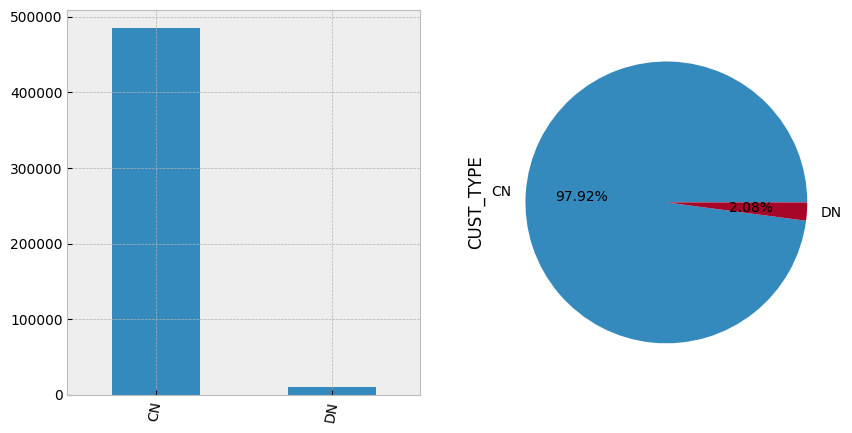

HOAT DONG    205239
DONG BANG    199664
NGU DONG      90180
Name: CUST_STATUS, dtype: int64

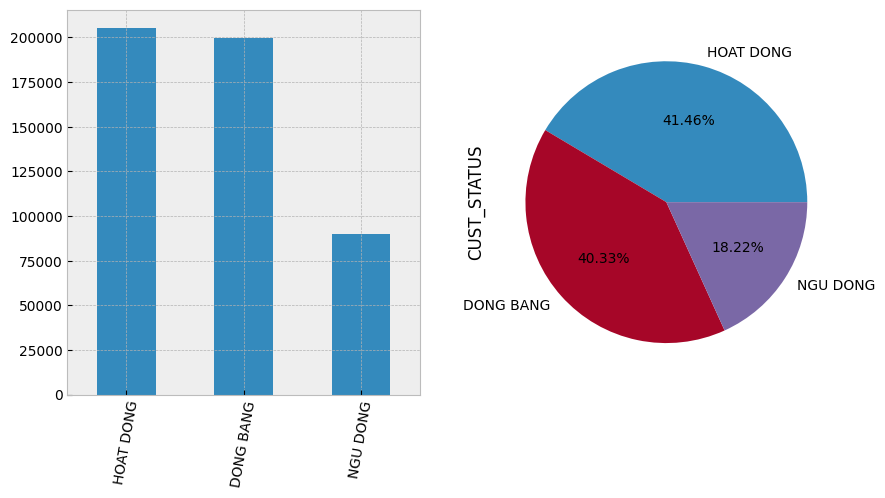

,default_func,remove_mode_value,logx
count,324441.000,9252.000,9252.000
count_pct_chg,100.000,-97.148,-97.148
mean,0.029,1.000,0.000
mean_pct_chg,100.000,3406.712,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


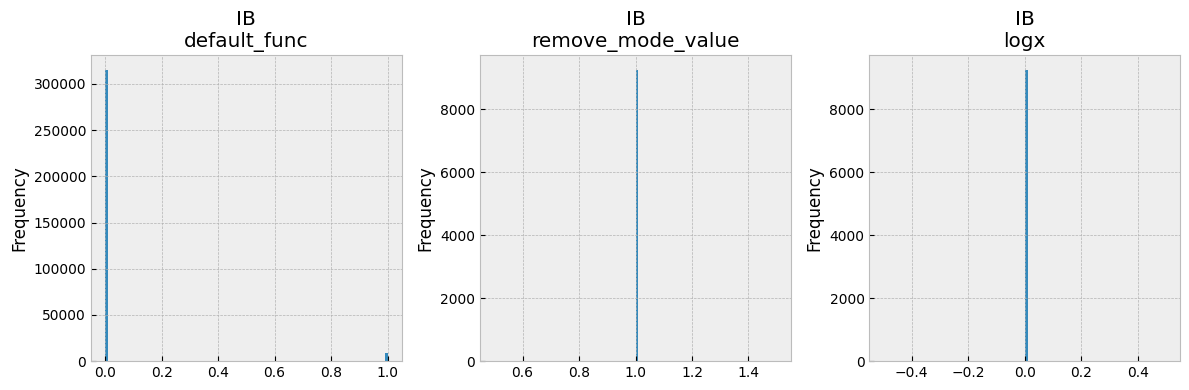

,default_func,remove_mode_value,logx
count,324441.000,33675.000,33675.000
count_pct_chg,100.000,-89.621,-89.621
mean,0.104,1.000,0.000
mean_pct_chg,100.000,863.448,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


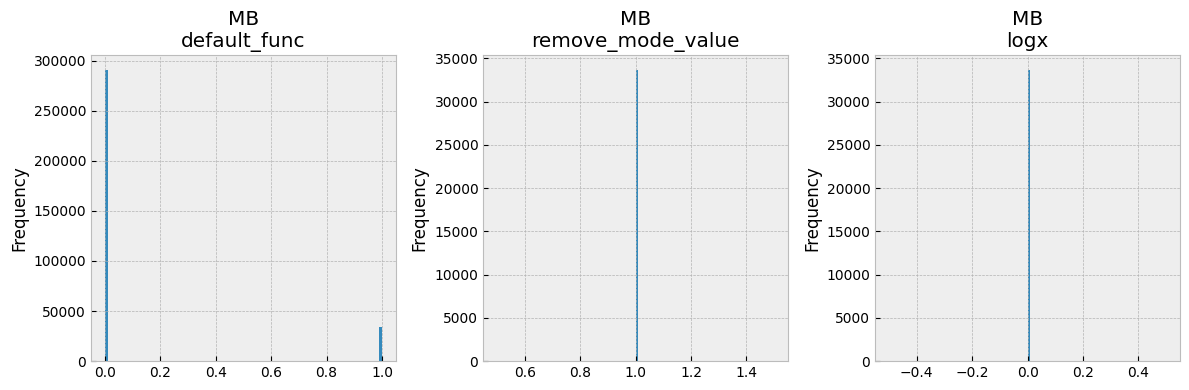

,default_func,remove_mode_value,logx
count,314147.000,69946.000,69946.000
count_pct_chg,100.000,-77.735,-77.735
mean,0.223,1.000,0.000
mean_pct_chg,100.000,349.128,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


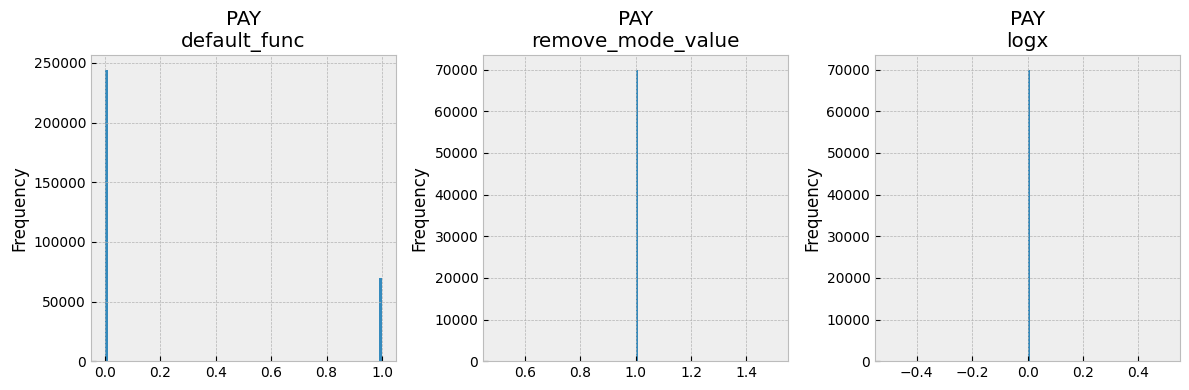

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,324441.000,71823.000,71823.000
count_pct_chg,100.000,-77.863,-77.863
mean,0.779,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


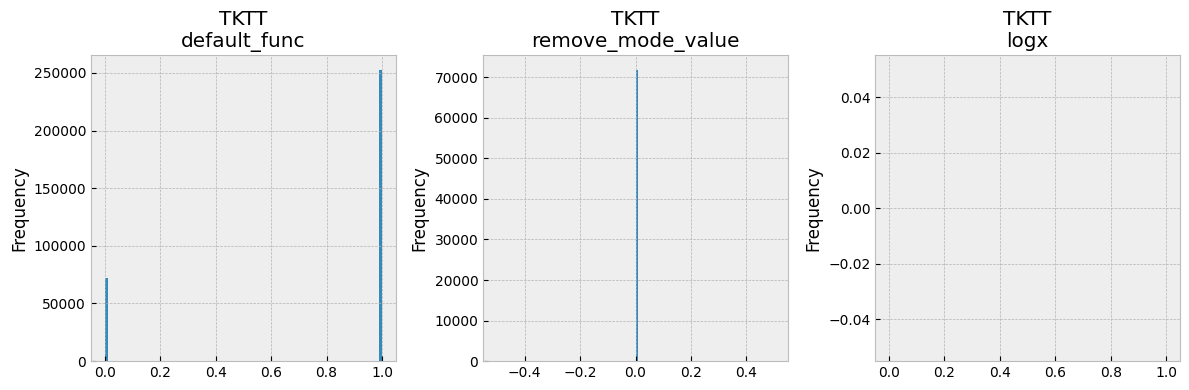

,default_func,remove_mode_value,logx
count,324441.000,33938.000,33938.000
count_pct_chg,100.000,-89.540,-89.540
mean,0.105,1.000,0.000
mean_pct_chg,100.000,855.981,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


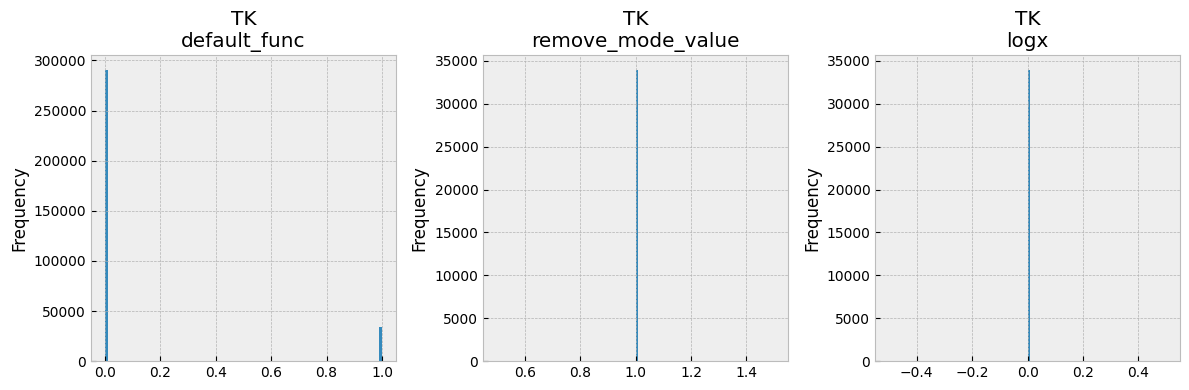

,default_func,remove_mode_value,logx
count,324441.000,12991.000,12991.000
count_pct_chg,100.000,-95.996,-95.996
mean,0.040,1.000,0.000
mean_pct_chg,100.000,2397.429,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


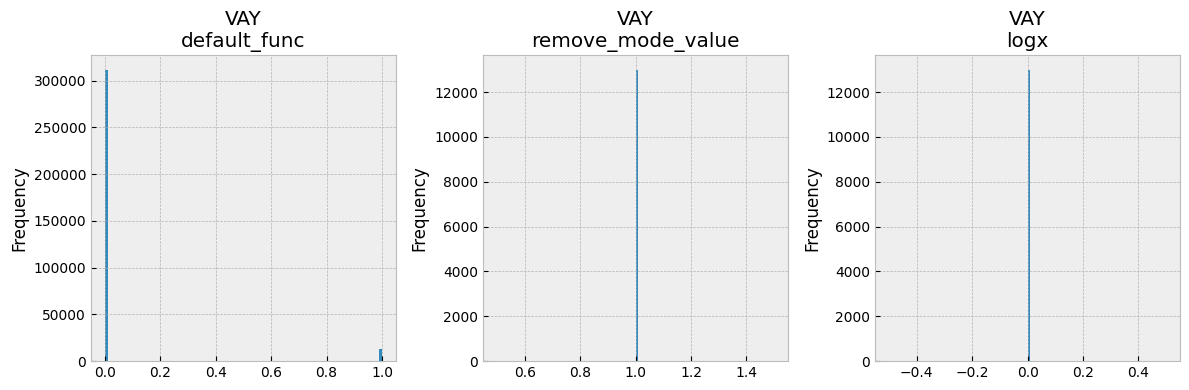

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,202026.000,9947.000,9947.000
count_pct_chg,100.000,-95.076,-95.076
mean,0.951,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


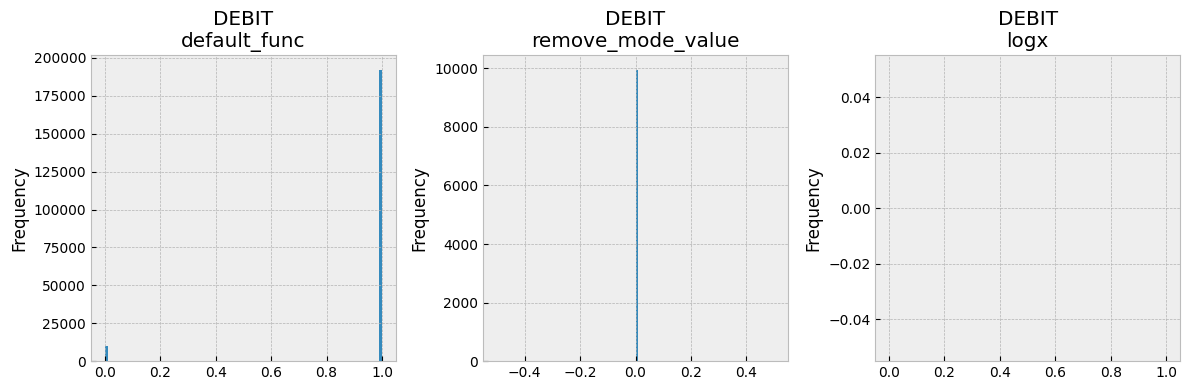

,default_func,remove_mode_value,logx
count,10294.000,226.000,226.000
count_pct_chg,100.000,-97.805,-97.805
mean,0.022,1.000,0.000
mean_pct_chg,100.000,4454.867,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


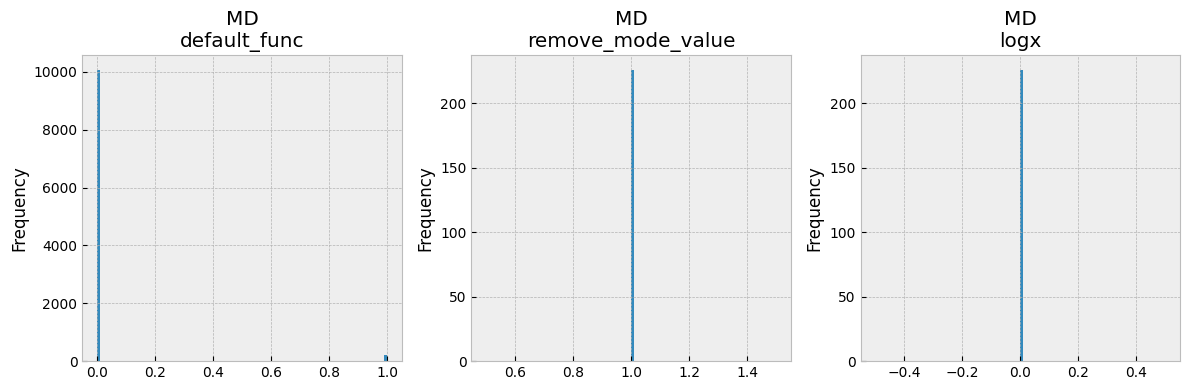

,default_func,remove_mode_value,logx
count,10294.000,20.000,20.000
count_pct_chg,100.000,-99.806,-99.806
mean,0.002,1.000,0.000
mean_pct_chg,100.000,51370.000,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


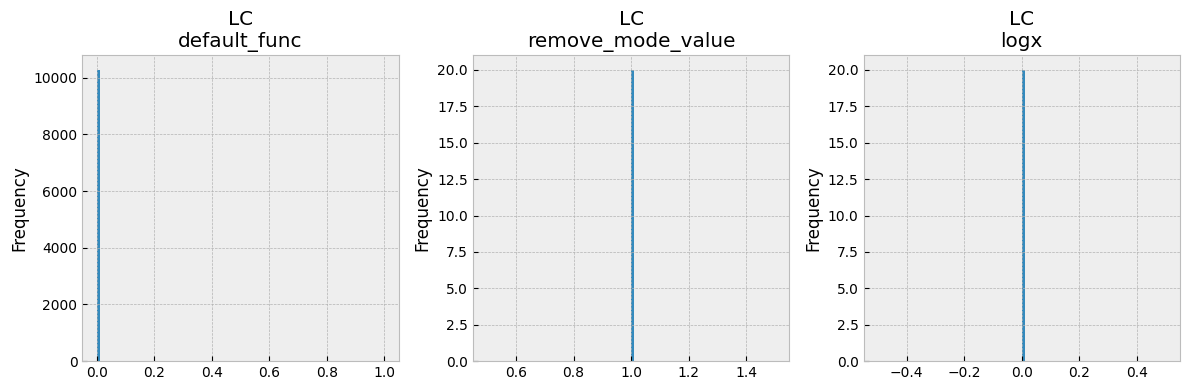

,default_func,remove_mode_value,logx
count,10294.000,255.000,255.000
count_pct_chg,100.000,-97.523,-97.523
mean,0.025,1.000,0.000
mean_pct_chg,100.000,3936.863,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


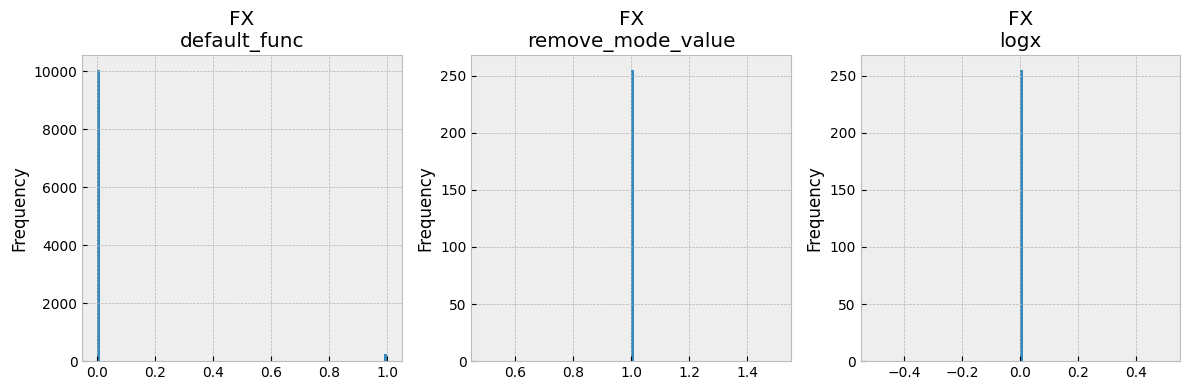

,default_func,remove_mode_value,logx
count,10294.000,254.000,254.000
count_pct_chg,100.000,-97.533,-97.533
mean,0.025,1.000,0.000
mean_pct_chg,100.000,3952.756,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


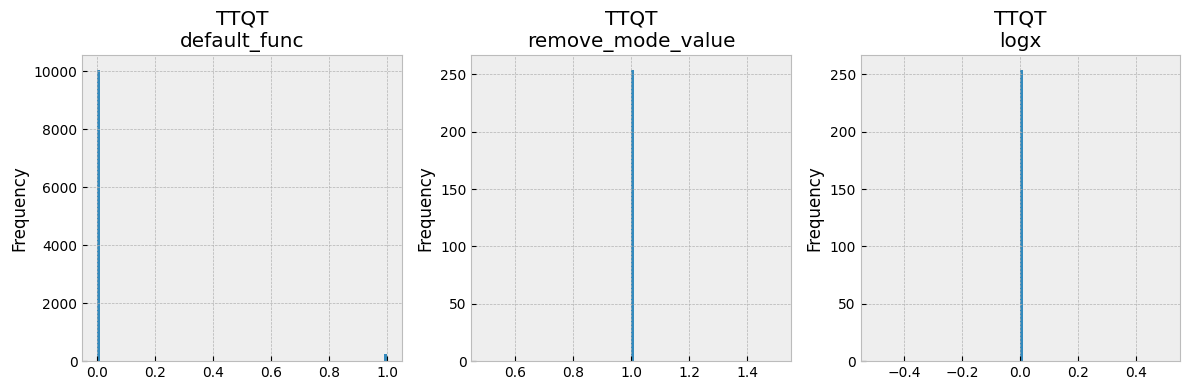

,default_func,remove_mode_value,logx
count,495083.000,30075.000,30075.000
count_pct_chg,100.000,-93.925,-93.925
mean,0.061,1.000,0.000
mean_pct_chg,100.000,1546.161,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


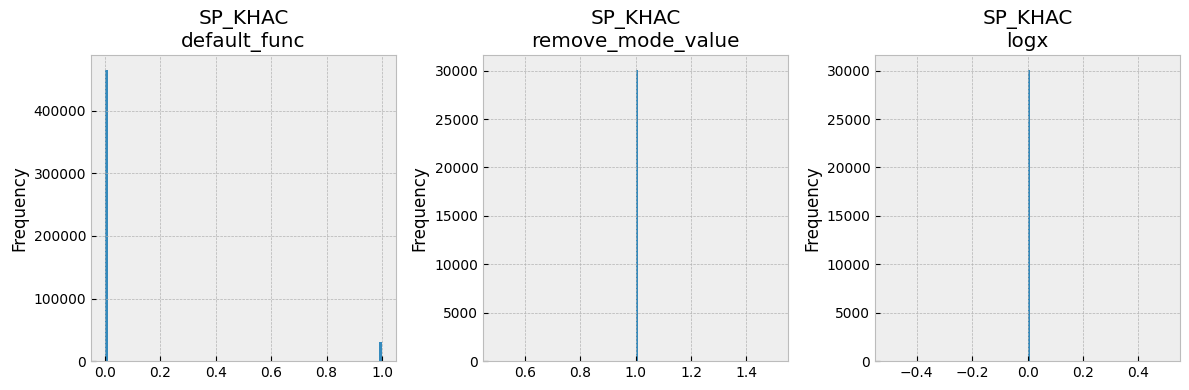

,default_func,remove_mode_value,logx
count,324441.000,65925.000,65925.000
count_pct_chg,100.000,-79.680,-79.680
mean,0.203,1.000,0.000
mean_pct_chg,100.000,392.137,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


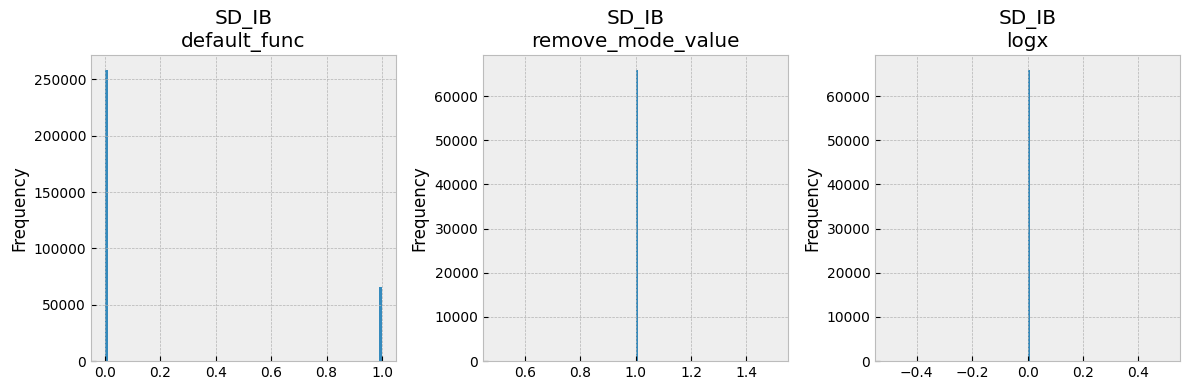

,default_func,remove_mode_value,logx
count,324441.000,54086.000,54086.000
count_pct_chg,100.000,-83.329,-83.329
mean,0.167,1.000,0.000
mean_pct_chg,100.000,499.861,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


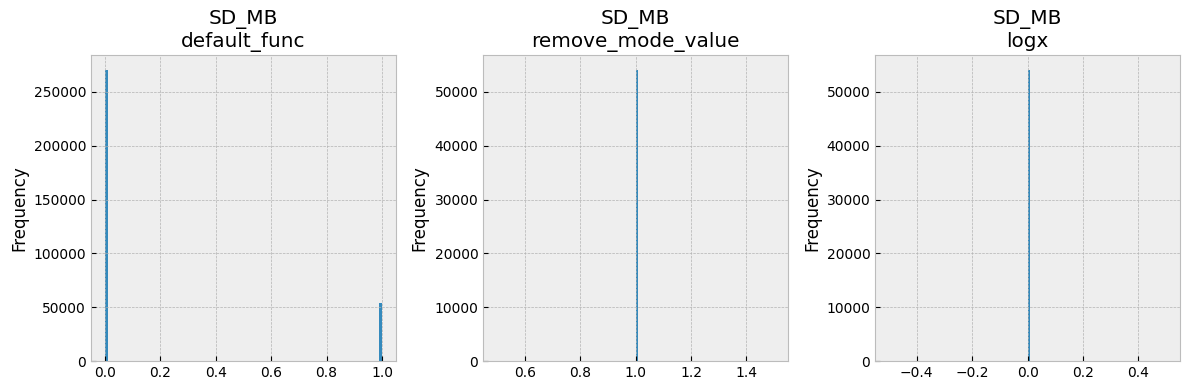

,default_func,remove_mode_value,logx
count,314147.000,87177.000,87177.000
count_pct_chg,100.000,-72.250,-72.250
mean,0.278,1.000,0.000
mean_pct_chg,100.000,260.355,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


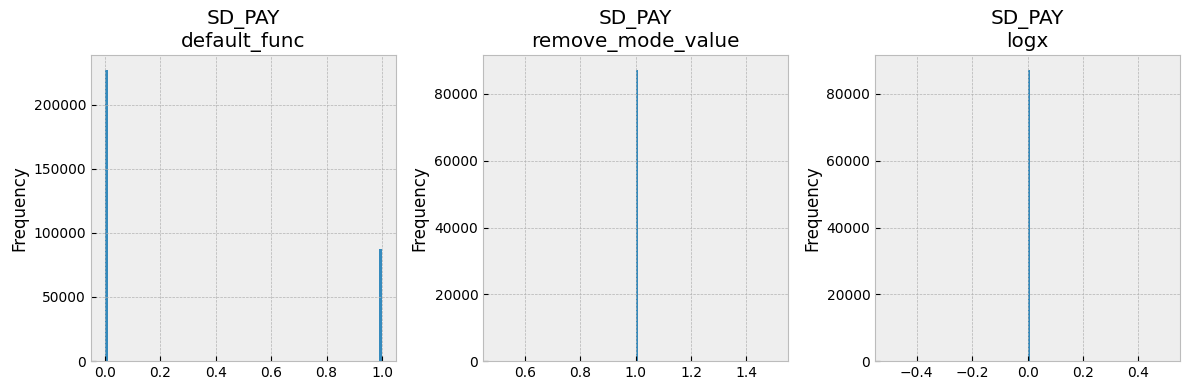

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,324441.000,67713.000,67713.000
count_pct_chg,100.000,-79.129,-79.129
mean,0.791,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


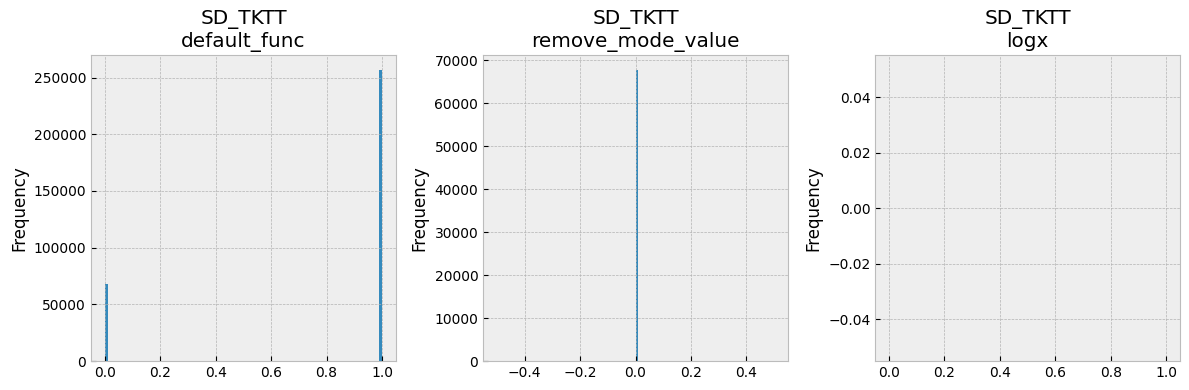

,default_func,remove_mode_value,logx
count,324441.000,34365.000,34365.000
count_pct_chg,100.000,-89.408,-89.408
mean,0.106,1.000,0.000
mean_pct_chg,100.000,844.103,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


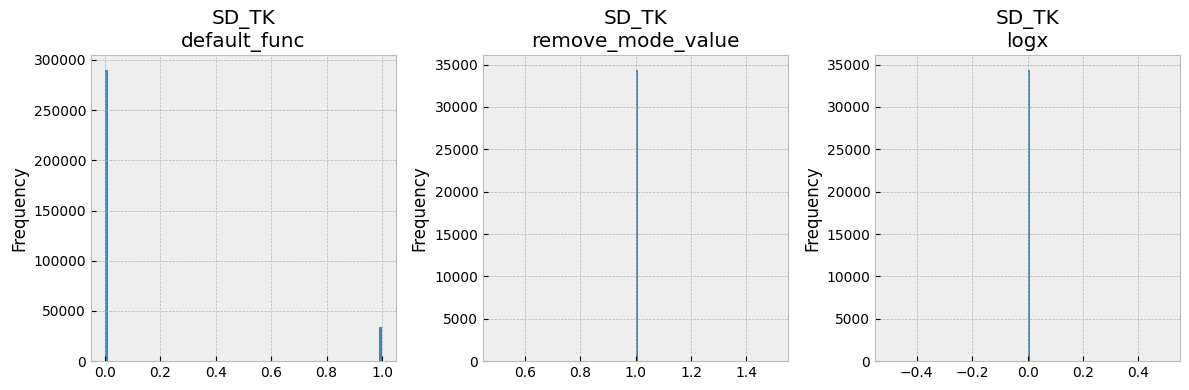

,default_func,remove_mode_value,logx
count,324441.000,12993.000,12993.000
count_pct_chg,100.000,-95.995,-95.995
mean,0.040,1.000,0.000
mean_pct_chg,100.000,2397.045,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


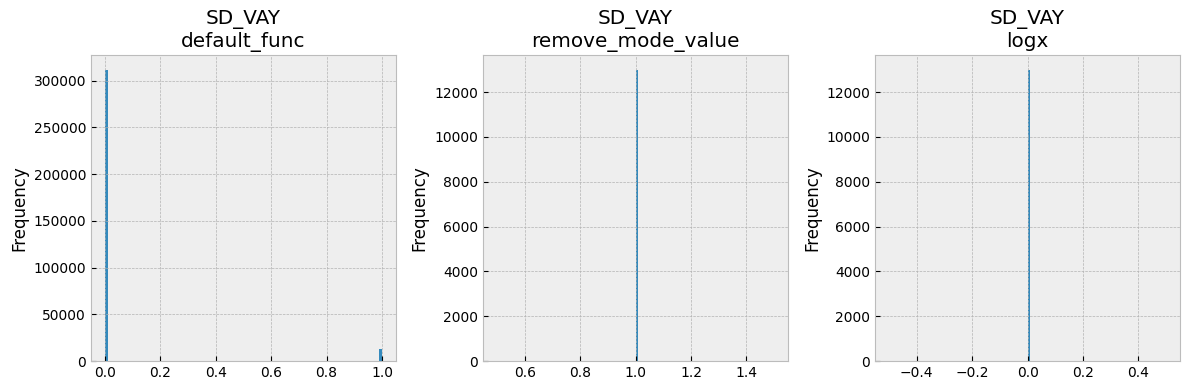

,default_func,remove_mode_value,logx
count,10294.000,226.000,226.000
count_pct_chg,100.000,-97.805,-97.805
mean,0.022,1.000,0.000
mean_pct_chg,100.000,4454.867,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


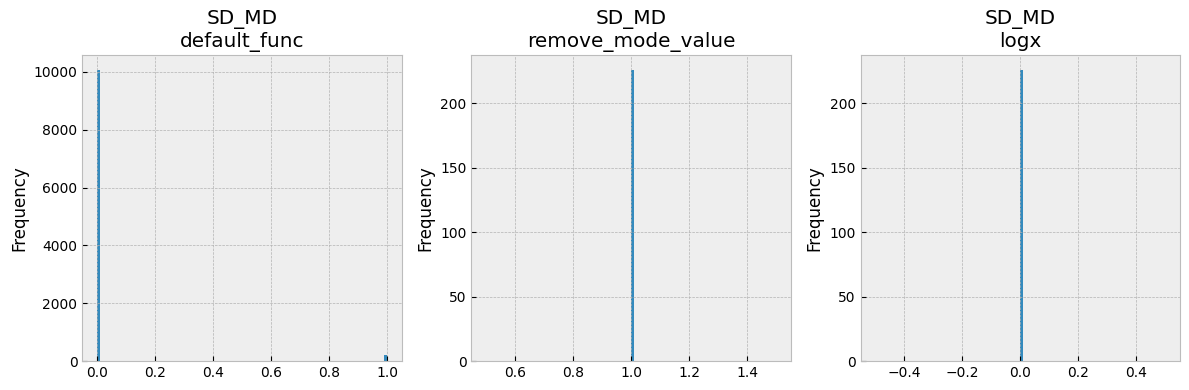

,default_func,remove_mode_value,logx
count,10294.000,20.000,20.000
count_pct_chg,100.000,-99.806,-99.806
mean,0.002,1.000,0.000
mean_pct_chg,100.000,51370.000,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


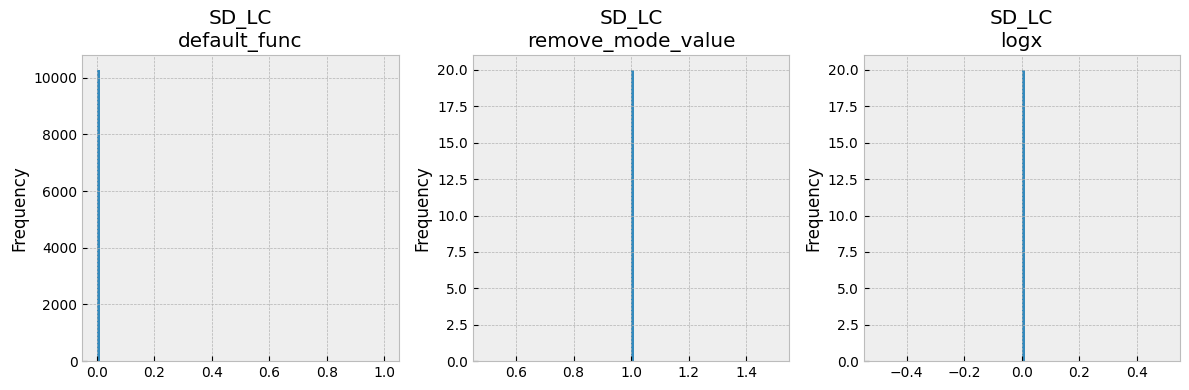

,default_func,remove_mode_value,logx
count,10294.000,255.000,255.000
count_pct_chg,100.000,-97.523,-97.523
mean,0.025,1.000,0.000
mean_pct_chg,100.000,3936.863,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


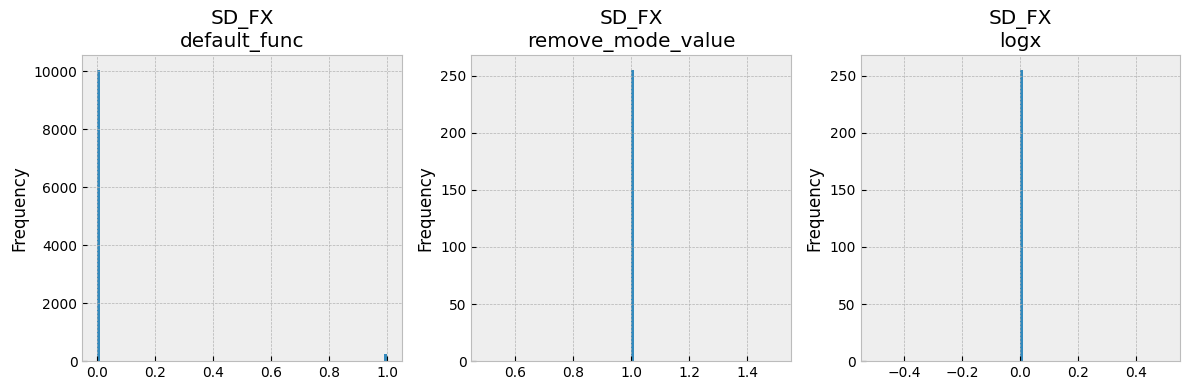

,default_func,remove_mode_value,logx
count,10294.000,254.000,254.000
count_pct_chg,100.000,-97.533,-97.533
mean,0.025,1.000,0.000
mean_pct_chg,100.000,3952.756,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


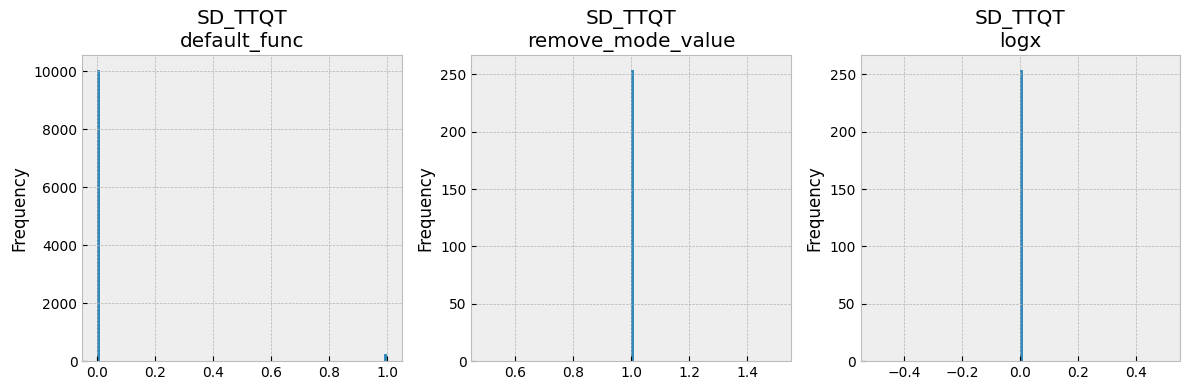

,default_func,remove_mode_value,logx
count,324441.000,21928.000,21928.000
count_pct_chg,100.000,-93.241,-93.241
mean,0.068,1.000,0.000
mean_pct_chg,100.000,1379.574,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


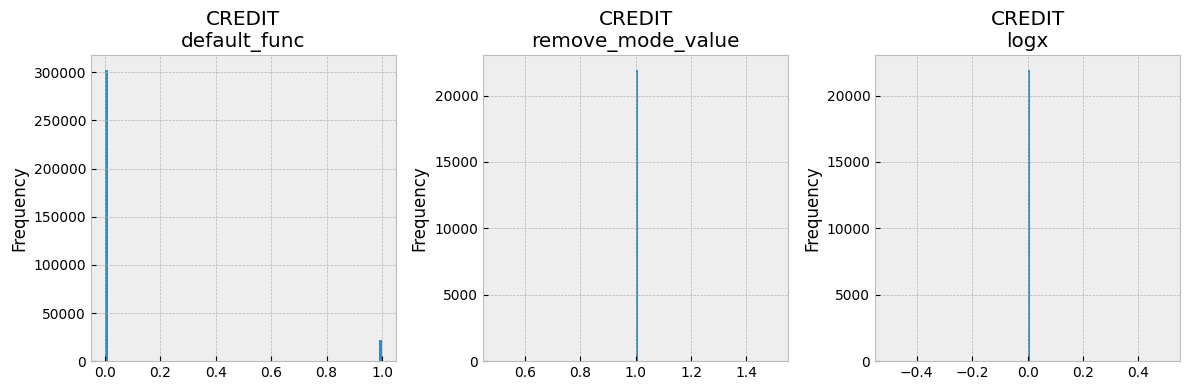

,default_func,remove_mode_value,logx
count,314147.000,2700.000,2700.000
count_pct_chg,100.000,-99.141,-99.141
mean,0.009,1.000,0.000
mean_pct_chg,100.000,11535.074,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


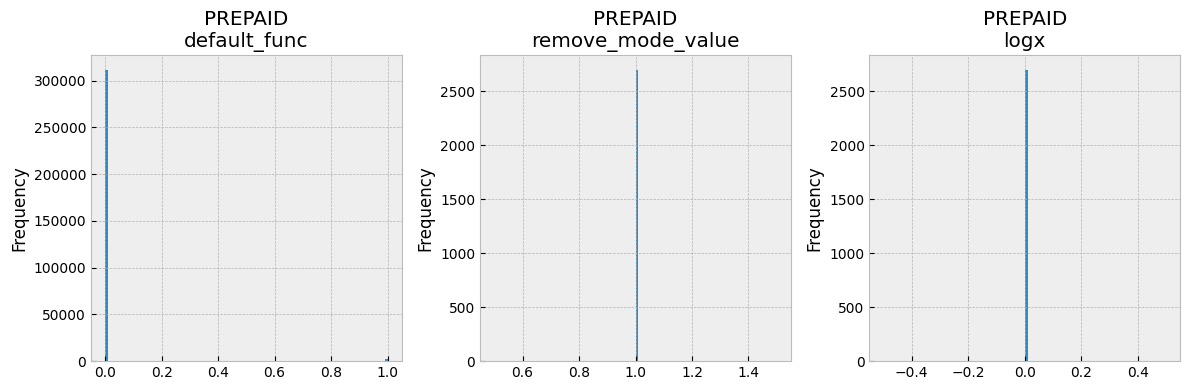

,default_func,remove_mode_value,logx
count,324441.000,22305.000,22305.000
count_pct_chg,100.000,-93.125,-93.125
mean,0.069,1.000,0.000
mean_pct_chg,100.000,1354.566,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


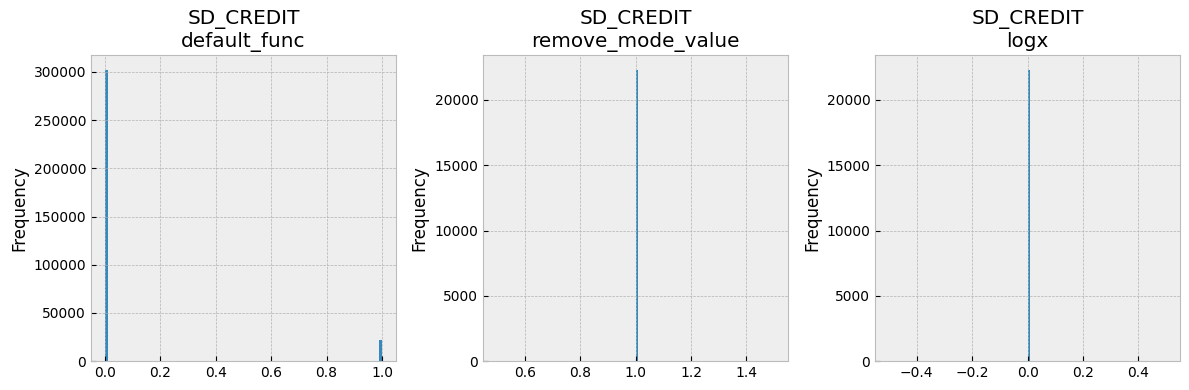

,default_func,remove_mode_value,logx
count,314147.000,2700.000,2700.000
count_pct_chg,100.000,-99.141,-99.141
mean,0.009,1.000,0.000
mean_pct_chg,100.000,11535.074,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


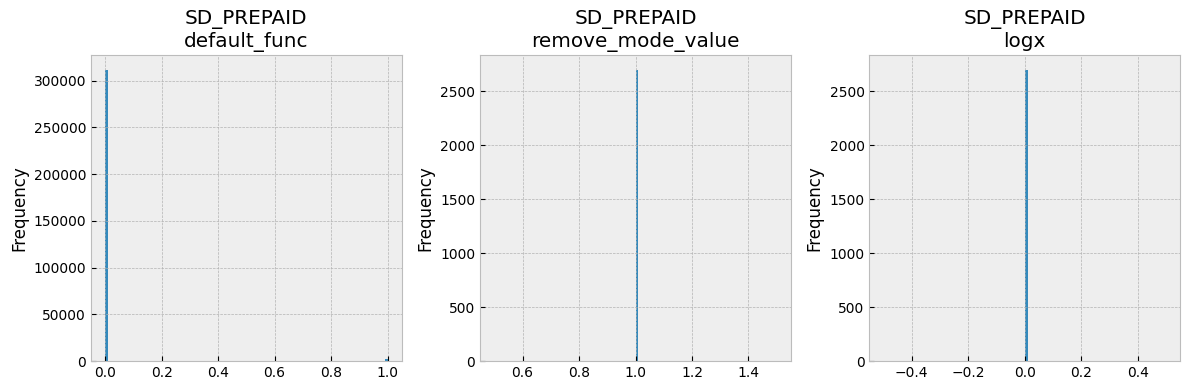

,default_func,remove_mode_value,logx
count,10294.000,84.000,84.000
count_pct_chg,100.000,-99.184,-99.184
mean,0.008,1.000,0.000
mean_pct_chg,100.000,12154.762,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


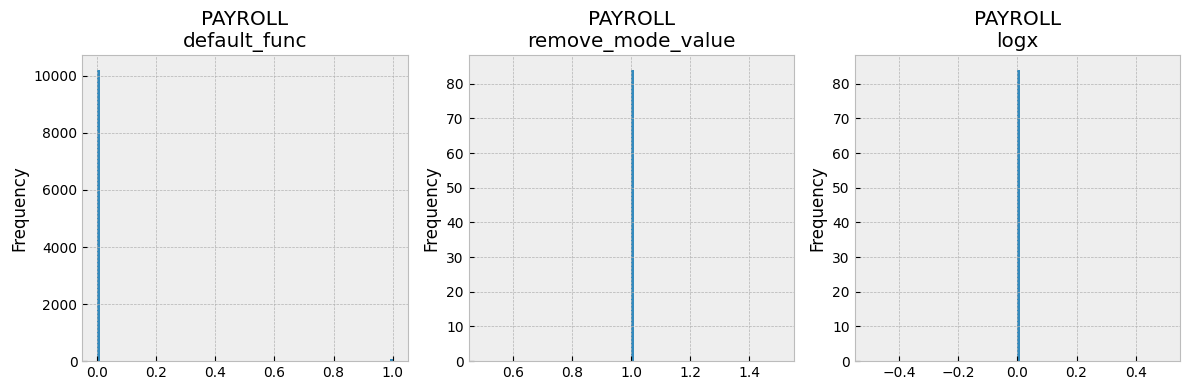

,default_func,remove_mode_value,logx
count,10294.000,84.000,84.000
count_pct_chg,100.000,-99.184,-99.184
mean,0.008,1.000,0.000
mean_pct_chg,100.000,12154.762,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


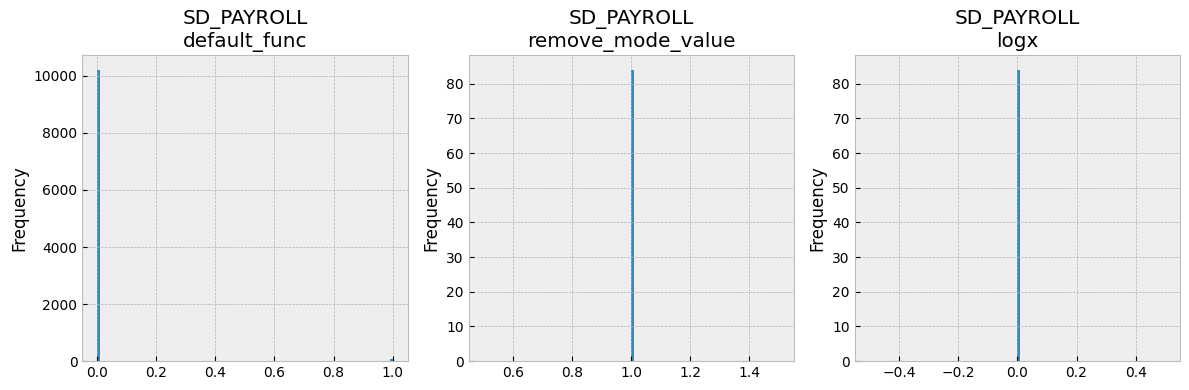

,default_func,remove_mode_value,logx
count,495083.000,29446.000,29446.000
count_pct_chg,100.000,-94.052,-94.052
mean,0.059,1.000,0.000
mean_pct_chg,100.000,1581.325,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


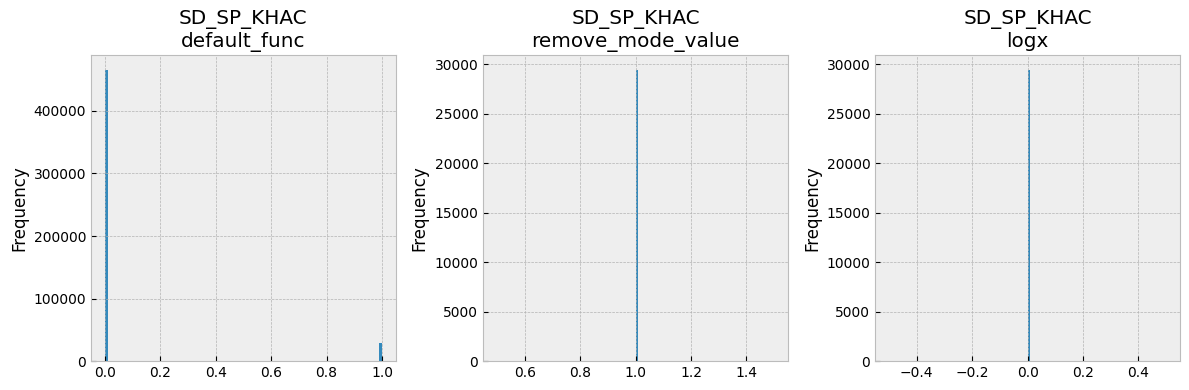

,default_func,remove_mode_value,logx
count,495083.000,13708.000,13708.000
count_pct_chg,100.000,-97.231,-97.231
mean,20457321.764,738843903.627,17.215
mean_pct_chg,100.000,3511.636,-100.000
median,0.000,100000000.000,18.421
median_pct_chg,100.000,inf,inf
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,910350927373.000,910350927373.000,27.537
max_pct_chg,100.000,0.000,-100.000


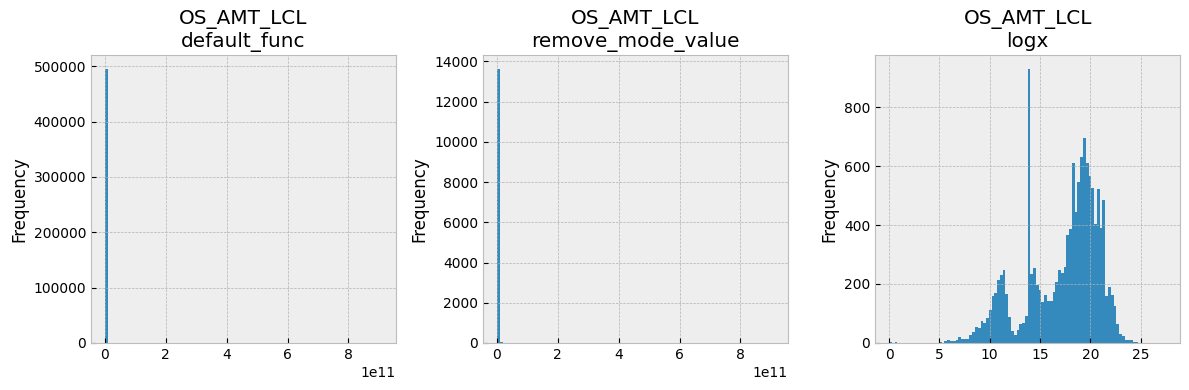

,default_func,remove_mode_value,logx
count,495083.000,245492.000,245492.000
count_pct_chg,100.000,-50.414,-50.414
mean,29078164.933,58641850.364,12.067
mean_pct_chg,100.000,101.670,-100.000
median,0.000,60969.000,11.018
median_pct_chg,100.000,inf,inf
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,642767340554.000,642767340554.000,27.189
max_pct_chg,100.000,0.000,-100.000


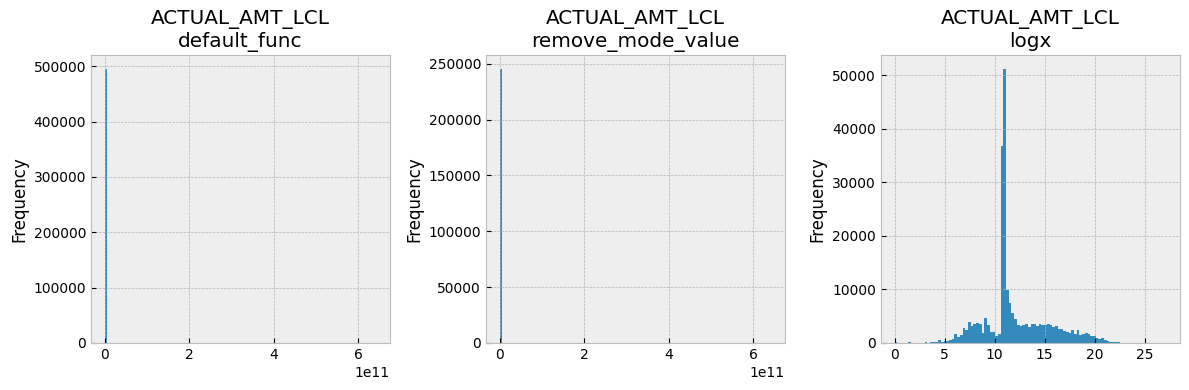

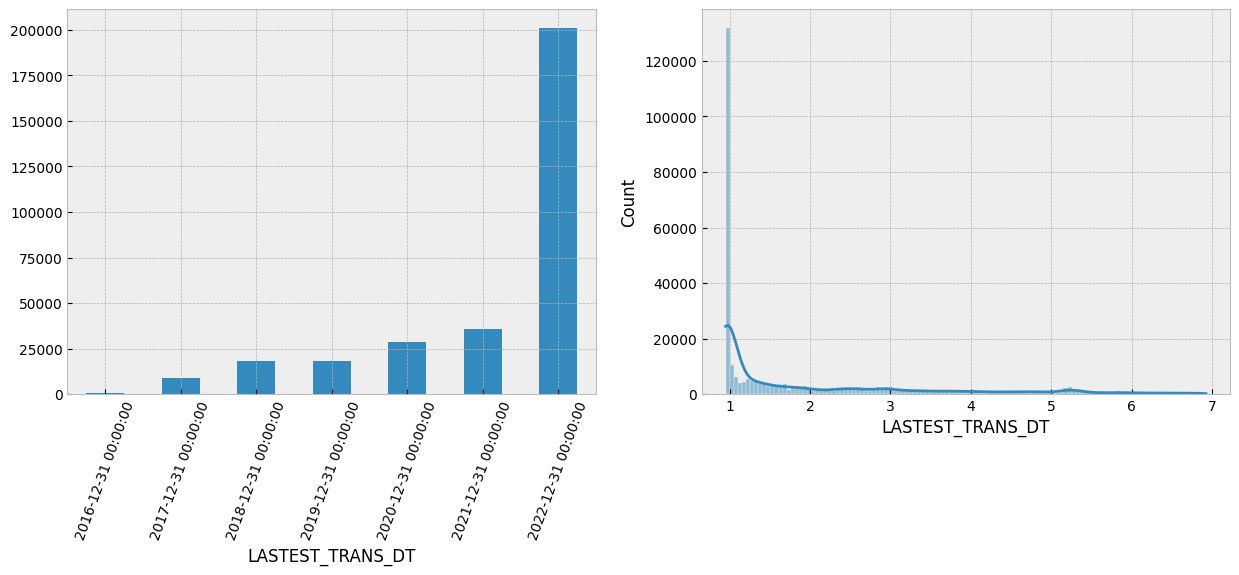

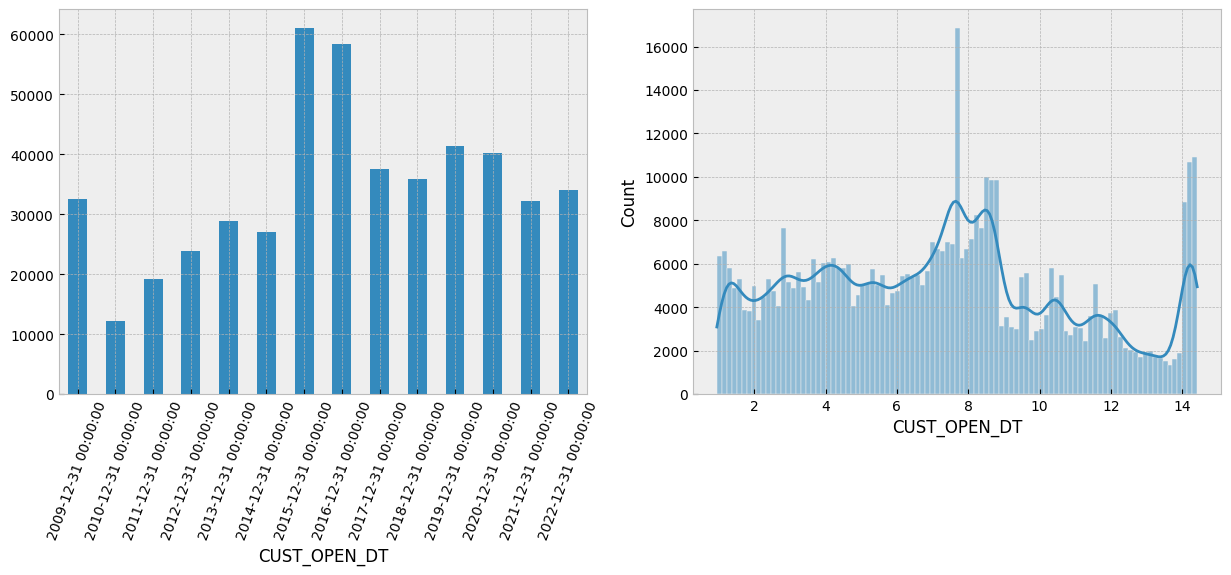

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
        'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
        'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
        'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
        'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
        'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
        'CUST_OPEN_DT'],
       dtype='object'),
 40)

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['CUST_TYPE', 'CUST_STATUS', 'IB', 'MB', 'PAY', 'TKTT', 'TK', 'VAY',
        'DEBIT', 'MD', 'LC', 'FX', 'TTQT', 'SP_KHAC', 'SD_IB', 'SD_MB',
        'SD_PAY', 'SD_TKTT', 'SD_TK', 'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX',
        'SD_TTQT', 'CREDIT', 'PREPAID', 'SD_CREDIT', 'SD_PREPAID', 'PAYROLL',
        'SD_PAYROLL', 'SD_SP_KHAC', 'OS_AMT_LCL', 'ACTUAL_AMT_LCL',
        'LASTEST_TRANS_DT', 'CUST_OPEN_DT'],
       dtype='object', name='Column'),
 35)

In [27]:
df.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3

# DETAIL

In [28]:
df.PROCESS_DT.max()

Timestamp('2022-11-18 00:00:00')

In [29]:
df.CUSTOMER_CDE.nunique()

495076

In [66]:
df

,PROCESS_DT,CUSTOMER_CDE,CUST_TYPE,CUST_STATUS,BH,IB,MB,PAY,TKTT,TK,...,SD_CREDIT,SD_PREPAID,PAYROLL,SD_PAYROLL,SD_SP_KHAC,OS_AMT_LCL,ACTUAL_AMT_LCL,LASTEST_TRANS_DT,REC_CREATE_DT,CUST_OPEN_DT
0,2022-11-18,12348538,CN,NGU DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,1200.000,2019-04-19,2022-11-19 15:02:43,2018-09-22
1,2022-11-18,1234856,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,NaT,2022-11-19 15:02:43,2009-09-05
2,2022-11-18,12348562,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,2020-05-05,2022-11-19 15:02:43,2018-09-22
3,2022-11-18,12349647,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,NaT,2022-11-19 15:02:43,2018-09-22
4,2022-11-18,12349656,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,NaT,2022-11-19 15:02:43,2018-09-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495078,2022-11-18,10488667,CN,HOAT DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,63601.000,2022-03-17,2022-11-19 15:02:43,2017-05-04
495079,2022-11-18,10488677,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,NaT,2022-11-19 15:02:43,2017-05-04
495080,2022-11-18,10488684,CN,NGU DONG,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,NaN,NaN,1,0.000,0.000,2021-08-17,2022-11-19 15:02:43,2017-05-04
495081,2022-11-18,10488697,CN,HOAT DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,9616778.000,2022-11-15,2022-11-19 15:02:43,2017-05-04


In [67]:
df.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT'],
      dtype='object')

<Axes: ylabel='CUST_TYPE'>

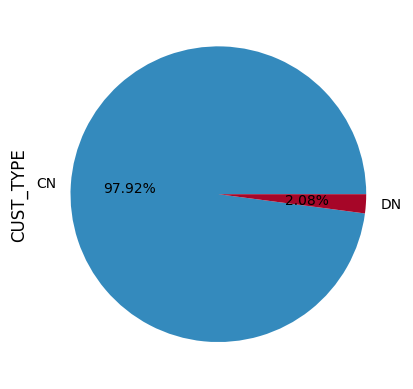

In [94]:
df.CUST_TYPE.value_counts(normalize=True).plot(kind='pie',autopct='%.2f%%')

In [85]:
df1 = df[df['CUST_TYPE']=='CN']

In [86]:
PROD = 'MB'
value_name = 'perc'

In [87]:
df1 = df1.fillna('NA')
# df1 = df1.fillna(0)

In [88]:
df2 = df1[PROD].value_counts(dropna=False)

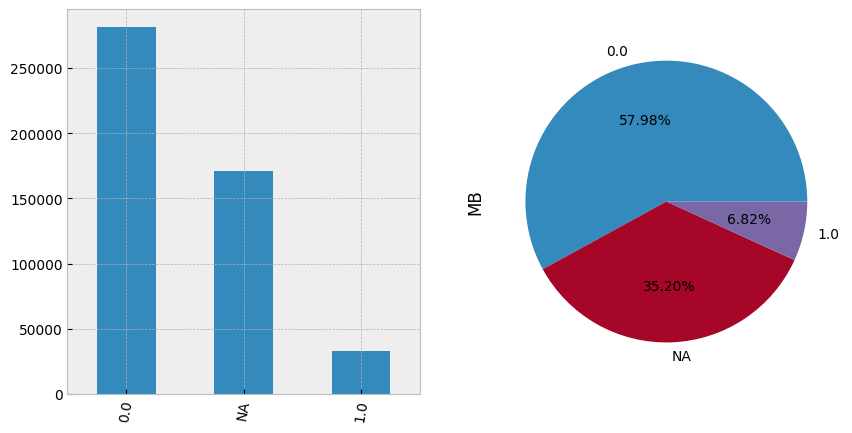

In [89]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
# display(df2)
df2.plot(kind='bar', rot=80,ax=axs[0])
df2.plot(kind='pie', autopct='%.2f%%',ax=axs[1])
plt.savefig(os.path.join(NAMESPACE.img, f'{PROD}.jpg'), dpi=500)
plt.show()

In [90]:
df2 = df1.groupby('CUST_STATUS')[PROD].value_counts(dropna=False, normalize=False).to_frame(name=value_name).reset_index()

In [91]:
df2[value_name] = df2[value_name] / df2[value_name].sum()

<Axes: xlabel='MB', ylabel='perc'>

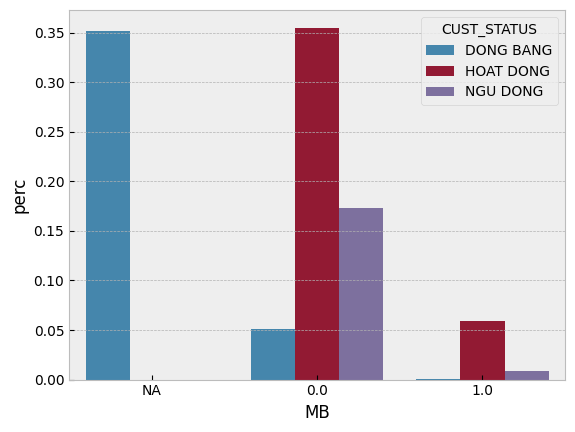

In [92]:
sns.barplot(df2[df2[PROD].isin(['NA',0,1])],x=PROD, y=value_name,hue='CUST_STATUS')
# plt.title('Ti le phan bo')